## X-Ray Body Part Competition FastAI + PNG Starter

This notebook will show how to classify converted images from DICOM to PNG to create a classifier using FAST.AI

The dataset contains imagens in PNG and Metadata in CSV format.  

https://www.kaggle.com/datasets/ibombonato/xray-body-images-in-png-unifesp-competion

This can speed up the train many times, since it takes a long time to load/read DICOM files.

Please, **upvote** the **dataset** and this **notebook** if it helps you in some manner.

In [1]:
!pip install -U fastai
!pip install fastai --upgrade
!pip install kaggle

from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ibombonato/xray-body-images-in-png-unifesp-competion

%cd /content
!unzip -qq "/content/xray-body-images-in-png-unifesp-competion.zip"

     |████████████████████████████████| 197 kB 6.1 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
 92% 185M/200M [00:02<00:00, 104MB/s]
100% 200M/200M [00:02<00:00, 87.4MB/s]
/content


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import fastai
from fastai.vision.all import *


INPUT_PATH = "/content"
EPOCHS = 50

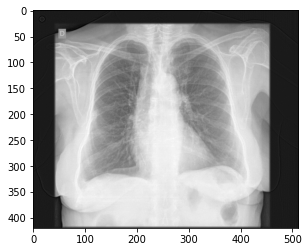

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

im = plt.imread("/content/image_png.png")
plt.imshow(im, cmap='gray')

In [9]:
df_train = pd.read_csv('/content/train_df.csv')
df_train['Target'] = df_train['Target'].apply(lambda x: x.strip())

### Simple split for training.

A better split strategy should improve your score.


In [10]:
from sklearn.model_selection import ShuffleSplit

X = df_train
y = df_train['Target']
sss = ShuffleSplit(n_splits=1, test_size=.2, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

### Load and visualize the data

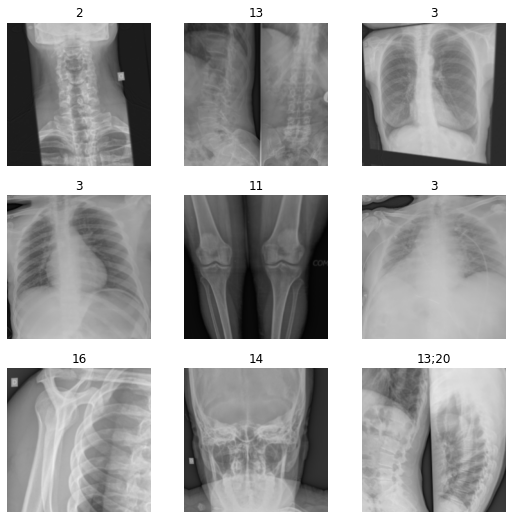

In [11]:
df_train['is_valid'] = False
df_train.loc[val_idx, 'is_valid'] = True

dls = ImageDataLoaders.from_df(df_train, 
                               fn_col = 'image_path',
                               label_col = 'Target',
                               label_delim = ' ',
                               valid_col='is_valid',
                               path = INPUT_PATH,
                               item_tfms=Resize(224), 
                               batch_tfms=aug_transforms(size=224))

dls.show_batch()

## Training phase

In [12]:
!mkdir ./model

In [13]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_micro = F1ScoreMulti(thresh=0.5, average='micro')
f1_weighted = F1ScoreMulti(thresh=0.5, average='weighted')
learn = cnn_learner(dls, resnet50, 
                    metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples, f1_micro, f1_weighted], 
                    model_dir='/content/gdrive/MyDrive/ESC/FinalProject')

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

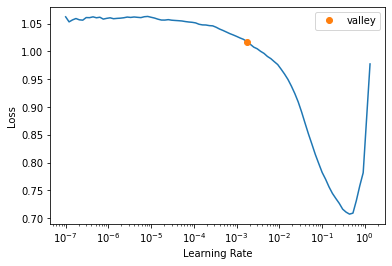

In [14]:
lr = learn.lr_find()

In [15]:
learn.fine_tune(EPOCHS, lr[0])

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.957334,0.788198,0.553683,0.142638,0.171364,0.165568,0.415998,00:31


epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.834539,0.656253,0.639107,0.174479,0.215559,0.202597,0.483462,00:38
1,0.816091,0.626649,0.657393,0.183916,0.224097,0.212549,0.495991,00:36
2,0.795223,0.606428,0.680773,0.192780,0.239725,0.225111,0.510504,00:36
3,0.770599,0.572813,0.721526,0.212776,0.273117,0.251404,0.530267,00:36
4,0.739800,0.547013,0.757968,0.230583,0.311429,0.278708,0.549005,00:36
5,0.707386,0.518914,0.804598,0.253460,0.376421,0.324300,0.568933,00:36
6,0.668472,0.452631,0.876829,0.326786,0.521730,0.432952,0.628565,00:36
7,0.623108,0.406116,0.925287,0.409028,0.651795,0.555210,0.682142,00:36
8,0.565039,0.321961,0.963297,0.565586,0.782492,0.712972,0.764804,00:36
9,0.498321,0.248015,0.980799,0.668992,0.857731,0.823529,0.832616,00:36


## View results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


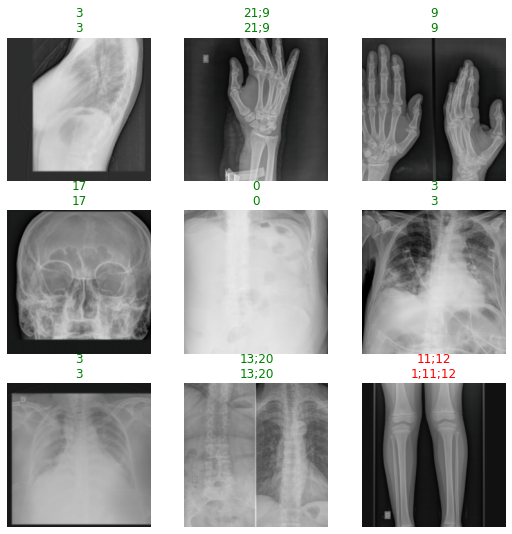

In [28]:
learn.show_results()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,target,predicted,probabilities,loss
0,14,13;20,"TensorBase([4.1365e-04, 4.0069e-04, 3.1984e-05, 5.8449e-05, 5.5041e-05, 9.9762e-01,\n 3.6893e-05, 1.9072e-04, 2.0587e-05, 7.4963e-05, 9.6206e-05, 7.5930e-05,\n 9.1648e-04, 9.9992e-01, 1.1385e-04, 3.0211e-05, 2.4601e-04, 6.1569e-05,\n 5.7573e-05, 1.1470e-04, 6.1748e-05, 2.0340e-04])",1.1675307750701904
1,14,13;20,"TensorBase([1.9953e-04, 2.1085e-04, 1.9254e-04, 9.6693e-05, 7.5850e-05, 9.9959e-01,\n 2.0134e-05, 3.5516e-04, 1.4970e-05, 1.2323e-04, 8.1934e-05, 1.4284e-04,\n 1.5493e-03, 9.5498e-01, 2.7640e-04, 1.6019e-06, 1.1650e-04, 8.4447e-05,\n 2.0524e-04, 1.3091e-04, 9.4561e-05, 2.0635e-04])",0.9866042137145996
2,21,1,"TensorBase([1.9276e-04, 9.9692e-01, 1.2867e-04, 1.4061e-04, 1.2267e-04, 2.0851e-04,\n 8.8378e-04, 1.1660e-04, 1.3169e-04, 2.7723e-04, 2.5305e-04, 1.1446e-04,\n 4.8259e-05, 1.8908e-04, 2.9678e-03, 5.4980e-05, 2.4790e-04, 8.1708e-04,\n 1.4176e-03, 4.2743e-05, 4.2292e-05, 3.8051e-04])",0.5276279449462891
3,14,3,"TensorBase([1.4843e-01, 7.5969e-04, 8.2701e-04, 1.6024e-03, 4.5844e-04, 3.0197e-03,\n 3.5629e-04, 3.8378e-04, 1.2225e-03, 3.5375e-04, 8.0586e-04, 8.0322e-04,\n 6.3142e-04, 2.3545e-03, 1.0274e-03, 9.0524e-01, 4.1356e-04, 1.1909e-03,\n 5.0646e-04, 5.3075e-04, 6.1382e-04, 3.7308e-04])",0.4761267602443695
4,6,11,"TensorBase([8.3471e-04, 4.6299e-04, 1.9918e-04, 9.9512e-01, 1.3069e-03, 6.0624e-04,\n 6.9071e-04, 4.9208e-04, 9.5272e-04, 2.2879e-04, 3.4747e-03, 6.8057e-05,\n 3.2246e-04, 7.5102e-04, 2.1117e-03, 1.5345e-04, 1.4471e-04, 6.9576e-04,\n 8.6191e-03, 2.8198e-04, 8.8012e-04, 6.5287e-04])",0.4587053656578064
5,9,21;9,"TensorBase([7.6531e-05, 2.8156e-05, 5.8069e-05, 3.0598e-05, 3.2135e-05, 7.0170e-05,\n 6.8163e-05, 9.1419e-05, 1.0929e-05, 4.8549e-05, 4.5877e-05, 2.3110e-05,\n 7.1025e-06, 4.0910e-05, 9.9991e-01, 2.9742e-06, 4.8865e-05, 5.5265e-05,\n 1.3032e-03, 3.7201e-05, 8.0265e-05, 1.0000e+00])",0.4228634834289551
6,10,15,"TensorBase([4.0344e-05, 2.8432e-04, 1.4116e-02, 3.3543e-04, 6.3141e-04, 1.2481e-04,\n 6.0586e-05, 9.9070e-01, 2.1290e-04, 2.7589e-04, 1.6160e-04, 7.7874e-03,\n 9.3800e-04, 1.3595e-04, 3.3731e-04, 6.9531e-05, 1.8187e-04, 2.2538e-04,\n 1.7655e-04, 7.5688e-05, 2.9766e-04, 4.4204e-05])",0.4068507254123688
7,5,11,"TensorBase([5.7171e-04, 9.1676e-02, 7.5299e-04, 9.6699e-01, 5.9824e-03, 1.3035e-03,\n 2.0052e-04, 6.1410e-04, 3.5474e-03, 1.8908e-03, 8.7387e-04, 9.8169e-04,\n 7.2738e-04, 6.0115e-04, 1.4994e-03, 1.8380e-05, 1.0819e-03, 1.3473e-02,\n 9.1977e-04, 4.2309e-03, 3.1149e-03, 7.5488e-04])",0.3565438687801361
8,15,10,"TensorBase([4.3632e-04, 8.7543e-05, 9.9536e-01, 2.1533e-03, 6.4018e-05, 1.7543e-05,\n 4.6714e-05, 1.1547e-01, 3.1267e-04, 1.6301e-04, 3.1035e-05, 5.2063e-04,\n 3.9390e-04, 6.2048e-05, 4.8621e-04, 2.7678e-05, 1.1276e-04, 1.3774e-05,\n 4.2163e-05, 5.0117e-04, 1.4847e-05, 1.0853e-04])",0.3426283895969391


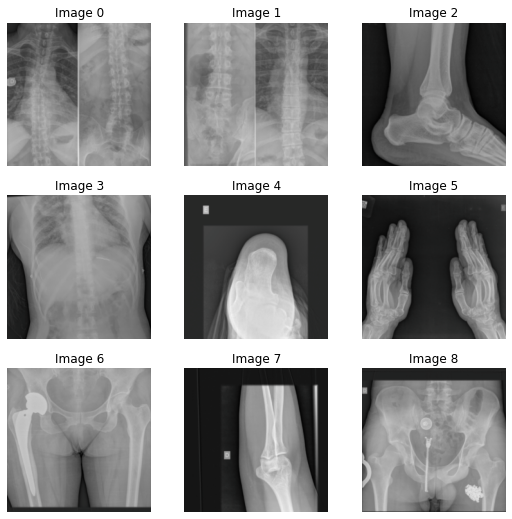

In [24]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

## Predict Test data

In [20]:
df_test = pd.read_csv(Path(INPUT_PATH, "test_df.csv"))
test_dl_df = dls.test_dl(df_test)

In [21]:
preds_test_df = learn.get_preds(dl=test_dl_df)

In [22]:
def get_preds_from_preds(pred_tensor):
    has_tsh = any(pred_tensor >= 0.5)
    if has_tsh: 
        return learn.dls.vocab[pred_tensor >= 0.5]
    else:
        return learn.dls.vocab[pred_tensor.argmax()]

def get_labels_from_preds(items):
    r = []
    for item in items:
        if(item.isdigit()):
            r.append(int(item))
    r = [str(i) for i in sorted(r)]
    return " ".join(r) if any(r) else "-1"

labelled_preds = [get_preds_from_preds(pred) for pred in preds_test_df[0]]
str_preds = [get_labels_from_preds(items) for items in labelled_preds]

In [23]:
df_test['Target'] = str_preds
df_submission = df_test[['SOPInstanceUID', 'Target']]
print(df_submission.shape)
df_submission.head()

(743, 2)


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106,9
1,1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590,3
2,1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225,9
3,1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805,3
4,1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414,3


## Save and submit the results

In [ ]:
learn.save('./learner_save_resnet50_25_epochs')

Path('/kaggle/working/model/learner_save_resnet50_25_epochs.pth')

In [ ]:
learn.export('/kaggle/working/model/learner_export_resnet50_25_epochs.pkl')

In [ ]:
df_submission.to_csv('submission.csv', index=False)